In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import sys
sys.path.append("..")
from utils import *

plt.style.use('ggplot')

## Data loading

,Kilopris (kr),Vekt (tonn),Year,Week,Month,Day of year,export_lag,log_returns
uke,,,,,,,,
2000-01-17,31.03,4043,2000,3,1,17,NaN,NaN
2000-01-24,30.95,3730,2000,4,1,24,NaN,-0.080579
2000-01-31,31.30,3831,2000,5,1,31,NaN,0.026718
2000-02-07,32.53,4415,2000,6,2,38,NaN,0.141882
2000-02-14,32.46,4617,2000,7,2,45,NaN,0.044737
...,...,...,...,...,...,...,...,...
2023-07-31,83.28,20469,2023,31,7,212,18577.0,0.043178
2023-08-07,80.26,21060,2023,32,8,219,20183.0,0.028464
2023-08-14,78.14,22698,2023,33,8,226,22368.0,0.074901


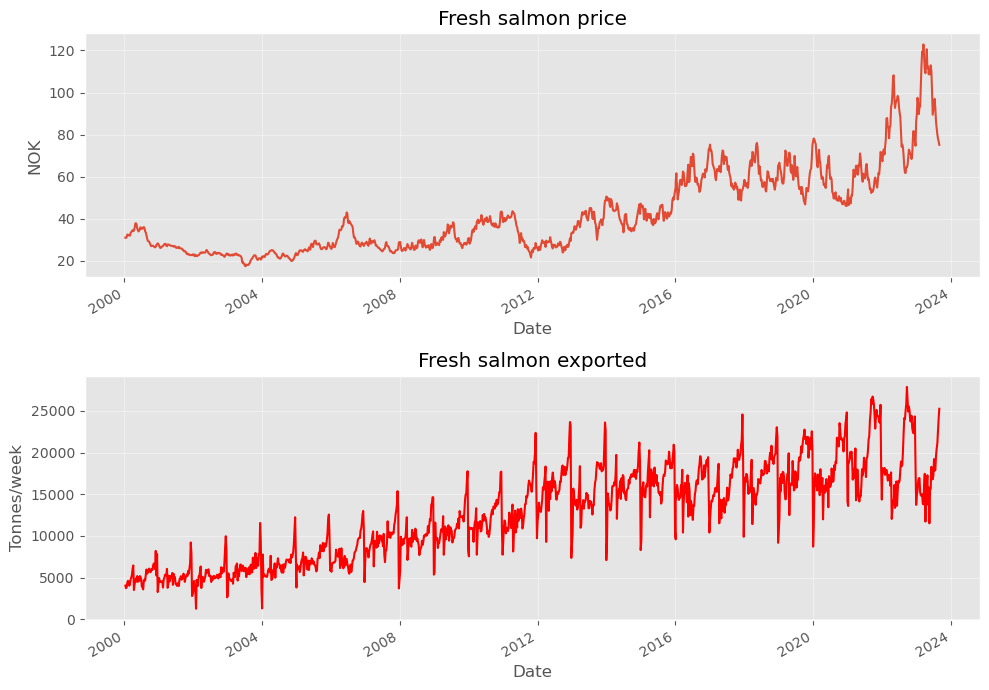

In [135]:
data_URL = 'https://www.ssb.no/statbank/sq/10085910'

data = import_salmon_data(data_URL)

add_lags(data)

data['export_lag'] = data['Vekt (tonn)'].shift(52)

data['log_returns'] = np.log(data['Vekt (tonn)']/data['Vekt (tonn)'].shift())
display(data)

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 7))

data['Kilopris (kr)'].plot(ax=ax1, ylabel='NOK')
data['Vekt (tonn)'].plot(ax=ax2, color='red', ylabel='Tonnes/week')
ax1.set_title('Fresh salmon price')
ax2.set_title('Fresh salmon exported')
ax1.grid(alpha=0.4); ax2.grid(alpha=0.4)
ax1.set_xlabel('Date'); ax2.set_xlabel('Date')
fig.tight_layout()

## Data analysis

,Kilopris (kr),Vekt (tonn),Year,Week,Month,Day of year,export_lag,log_returns
uke,,,,,,,,
2000-01-17,31.03,4043,2000,3,1,17,NaN,NaN
2000-01-24,30.95,3730,2000,4,1,24,NaN,-0.080579
2000-01-31,31.30,3831,2000,5,1,31,NaN,0.026718
2000-02-07,32.53,4415,2000,6,2,38,NaN,0.141882
2000-02-14,32.46,4617,2000,7,2,45,NaN,0.044737
...,...,...,...,...,...,...,...,...
2023-07-31,83.28,20469,2023,31,7,212,18577.0,0.043178
2023-08-07,80.26,21060,2023,32,8,219,20183.0,0.028464
2023-08-14,78.14,22698,2023,33,8,226,22368.0,0.074901


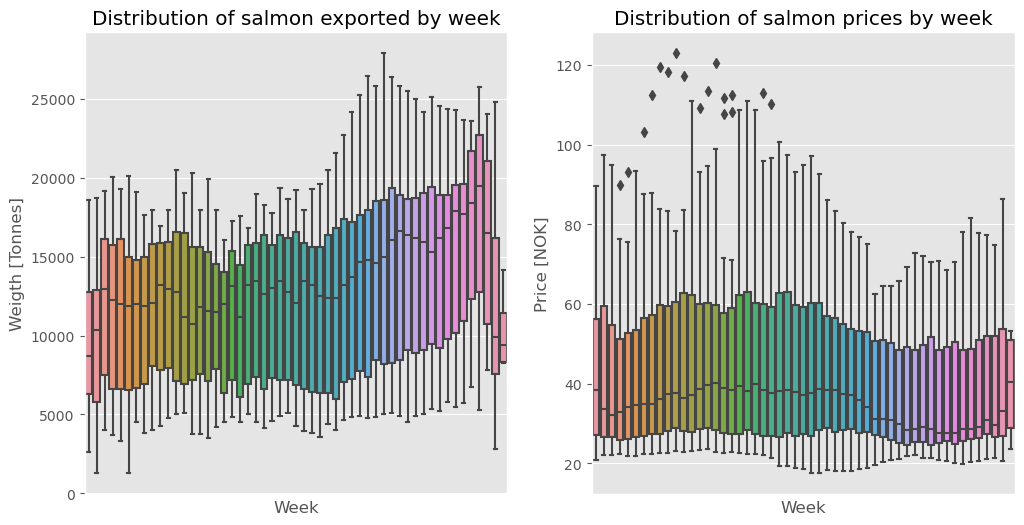

In [136]:
display(data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data=data, x='Week', y='Vekt (tonn)', ax=ax1)
sns.boxplot(data=data, x='Week', y='Kilopris (kr)', ax=ax2)
ax1.set_title('Distribution of salmon exported by week')
ax2.set_title('Distribution of salmon prices by week')
ax1.set_xticks([])
ax2.set_xticks([])
ax1.set_ylabel('Weigth [Tonnes]')
ax2.set_ylabel('Price [NOK]')

fig.savefig('boxplot.png')

[]

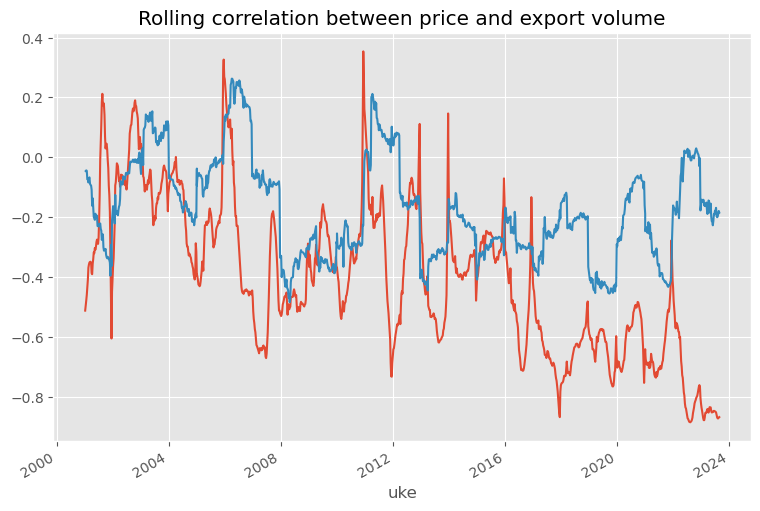

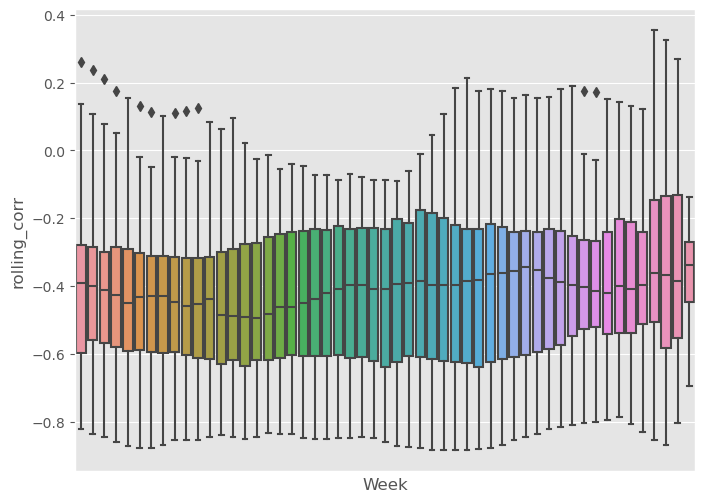

In [137]:
data['price_log'] = np.log(data['Kilopris (kr)']/data['Kilopris (kr)'].shift())
data['export_log'] = np.log(data['Vekt (tonn)']/data['Vekt (tonn)'].shift())

data['rolling_corr'] = data['Kilopris (kr)'].rolling(52).corr(data['Vekt (tonn)'])
data['rolling_corr_log'] = data['price_log'].rolling(52).corr(data['export_log'])

fig, ax = plt.subplots(figsize=(9, 6))

data['rolling_corr'].plot(ax=ax)
data['rolling_corr_log'].plot(ax=ax)

ax.set_title('Rolling correlation between price and export volume')

fig, (ax) = plt.subplots(figsize=(8, 6))
sns.boxplot(data=data, x='Week', y='rolling_corr', ax=ax)
ax.set_xticks([])

## Model training

In [138]:

display(data)

tscv = TimeSeriesSplit(n_splits=4)

features = ['Year', 'Week', 'Month', 'Day of year', 'export_lag']
targets = ['Vekt (tonn)', 'Kilopris (kr)']

reg_model = xgb.XGBRegressor(n_estimators=10000, early_stopping_rounds=1000)

data = data.copy()

# Iterate over the time series splits
for train_index, test_index in tscv.split(data):
    X_train, X_test = data[features].iloc[train_index], data[features].iloc[test_index]
    y_train, y_test = data[targets].iloc[train_index], data[targets].iloc[test_index]

    # Fit the XGBoost model
    reg_model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False
    )

    # Make predictions
    y_pred = reg_model.predict(X_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")


,Kilopris (kr),Vekt (tonn),Year,Week,Month,Day of year,export_lag,log_returns,price_log,export_log,rolling_corr,rolling_corr_log
uke,,,,,,,,,,,,
2000-01-17,31.03,4043,2000,3,1,17,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-24,30.95,3730,2000,4,1,24,NaN,-0.080579,-0.002581,-0.080579,NaN,NaN
2000-01-31,31.30,3831,2000,5,1,31,NaN,0.026718,0.011245,0.026718,NaN,NaN
2000-02-07,32.53,4415,2000,6,2,38,NaN,0.141882,0.038545,0.141882,NaN,NaN
2000-02-14,32.46,4617,2000,7,2,45,NaN,0.044737,-0.002154,0.044737,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,83.28,20469,2023,31,7,212,18577.0,0.043178,-0.033765,0.043178,-0.868453,-0.200006
2023-08-07,80.26,21060,2023,32,8,219,20183.0,0.028464,-0.036937,0.028464,-0.871935,-0.198207
2023-08-14,78.14,22698,2023,33,8,226,22368.0,0.074901,-0.026769,0.074901,-0.872193,-0.189741


Mean Squared Error: 2931428.4073
Mean Squared Error: 7092498.3004
Mean Squared Error: 1855805.5100
Mean Squared Error: 6361213.5291


## Model prediction

,Importance
Year,0.100704
Week,0.049130
Month,0.027274
Day of year,0.056204
export_lag,0.766688


,Year,Week,Month,Day of year,export_lag
Date,,,,,
2023-09-03,2023,35,9,246,19393
2023-09-10,2023,36,9,253,20563
2023-09-17,2023,37,9,260,21543
2023-09-24,2023,38,9,267,21783
2023-10-01,2023,39,10,274,20399
...,...,...,...,...,...
2027-05-30,2027,21,5,150,20469
2027-06-06,2027,22,6,157,21060
2027-06-13,2027,23,6,164,22698


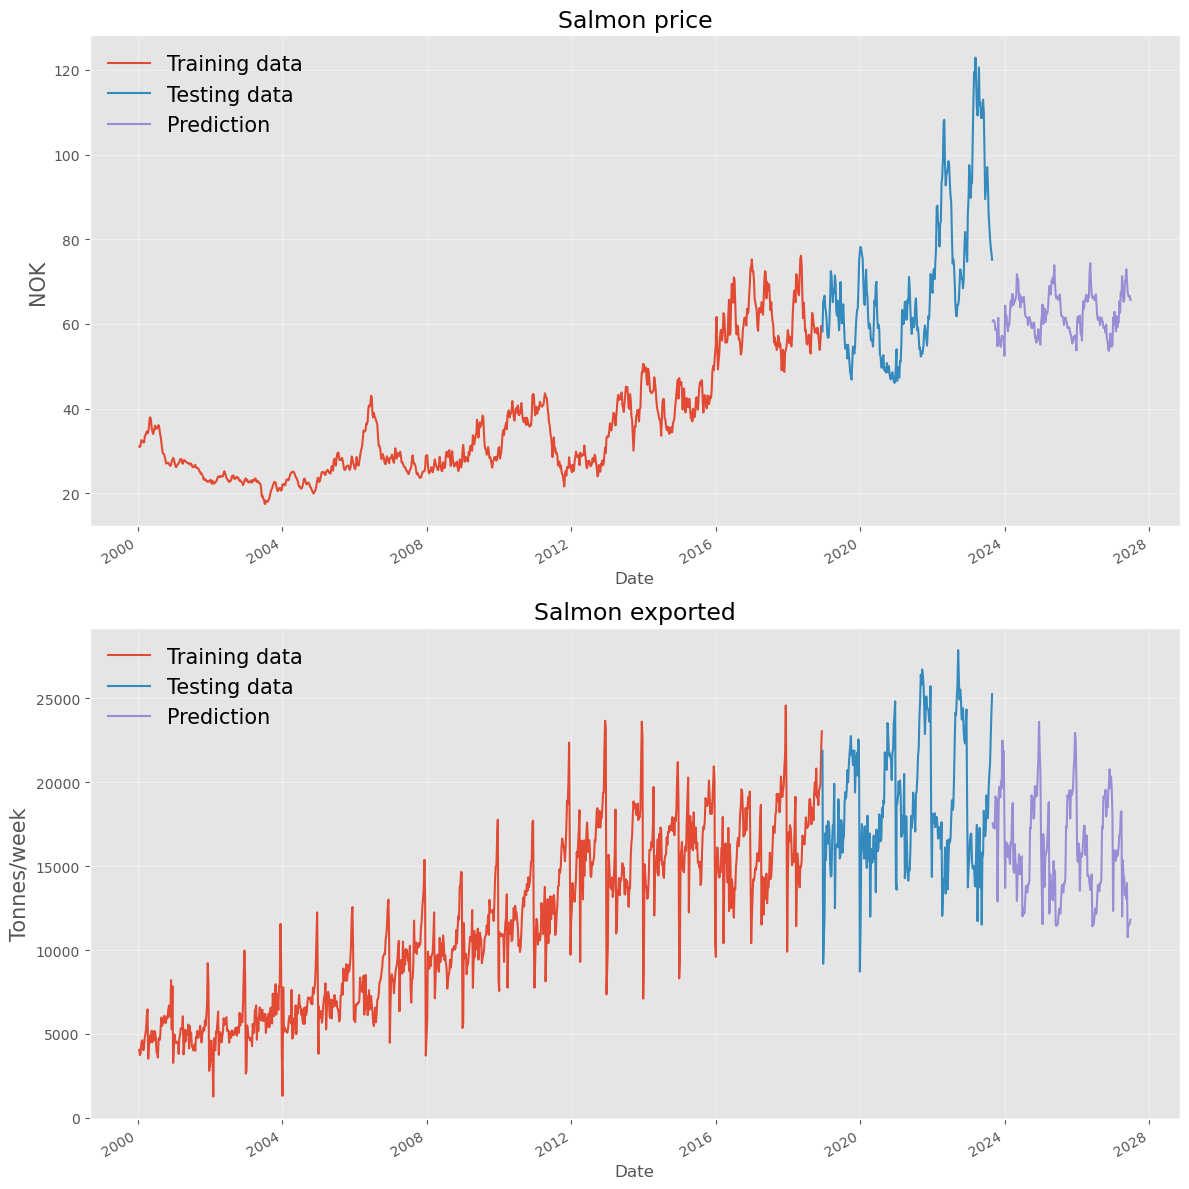

In [180]:
fi = pd.DataFrame(data=reg_model.feature_importances_, index=reg_model.feature_names_in_, columns=['Importance'])
display(fi)

future_dates = pd.DataFrame(
    pd.date_range(
        start=data.index.values[-1], 
        end='2030-09-07'
    ), columns=['Date']
)

lags = 200

future_dates = future_dates.set_index(future_dates['Date']).resample('W').first()[:lags]
add_lags(future_dates)

future_dates['export_lag'] = pd.DataFrame(data['Vekt (tonn)'].copy()[-lags:]).set_index(future_dates.index)

future_dates = future_dates.drop('Date', axis=1)

display(future_dates)

predictions = pd.DataFrame(reg_model.predict(future_dates), columns=targets, index=future_dates.index)

fig, axs = plt.subplots(2, figsize=(12, 12))

data_types = ['Training data', 'Testing data', 'Prediction']
label = ['NOK', 'Tonnes/week']
title = ['Salmon price', 'Salmon exported']

for i, target in enumerate(['Kilopris (kr)', 'Vekt (tonn)']):
    for j, df in enumerate([y_train, y_test, predictions]):
        df[target].plot(ax=axs[i], label=data_types[j])
        axs[i].legend(fontsize=15, frameon=False)
        axs[i].grid(alpha=0.4)
        axs[i].set_ylabel(label[i], fontsize=15)
        axs[i].set_title(title[i], fontsize=17)

fig.tight_layout()

# # Week 43:
# print('Week 43:')
# display(pd.DataFrame(predictions.loc['2023-10-23']))